# Ising Model

1. Define the Ising Model Hamiltonian  
   The **1D Transverse Field Ising Model (TFIM)** Hamiltonian is given by:

   $$ H = J \sum_{i} Z_i Z_{i+1} + h \sum_{i} Z_i $$

   where:

    - $J$ is the interaction strength between neighboring spins.
    - $h$ is the transverse field strength.
    - $X_{i}, Z_{i}$ are **Pauli matrices** acting on qubit $i$.





The total Hamiltonian can be written as:

$$
H = -J \sum_{i=1}^{N-1} \sigma_z^{(i)} \sigma_z^{(i+1)} + h \sum_{i=1}^{N} \sigma_x^{(i)} $$

This Hamiltonian consists of two **non commuting** terms $H_{z}$ and $H_{x}$, so we perform time evolution using Trotterization.


The time evolution operator for the full Hamiltonian is given by:

$$
U(t) = e^{-i H t}
$$
Since the Hamiltonian can be decomposed as:

$$
H = H_Z + H_X
$$

we apply the first-order Trotter decomposition:

$$
U(t) = e^{-i (H_Z + H_X) t} \approx \left( e^{-i H_Z \frac{t}{\delta t}} e^{-i H_X \frac{t}{\delta t}} \right)^{\delta t}
$$

where $N$ is the number of Trotter steps.

For small  $t/N$, the Trotterization error remains small, and increasing \( N \) improves the accuracy.

    

In [1]:
# configure some visualisations

from pytket.circuit.display import get_circuit_renderer

circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()

In [2]:
from pytket.utils import QubitPauliOperator
from pytket.pauli import Pauli, QubitPauliString
import networkx as nx
from pytket.circuit import Qubit

In [3]:
from pytket import Circuit
from sympy import symbols
from pytket.circuit.display import render_circuit_jupyter as draw
import numpy as np

In [4]:
from pytket import Circuit
from pytket.extensions.qiskit import AerBackend, AerStateBackend
from pytket.circuit import Circuit, Qubit

from pytket.utils.expectations import get_operator_expectation_value
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket.circuit.display import render_circuit_jupyter

from scipy.linalg import expm

import numpy as np
import matplotlib.pyplot as plt
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit import QuantumCircuit

In [20]:
# Sample parameters
n_qubits = 2
h=1.2
J=0.2
t = 10
delta = 0.1
t_arr = np.linspace(0, t, 100)


In [21]:
def H_1_block(n_qubits: int, t: float, delta: float, J: float) -> Circuit:
    H_1_block = QuantumCircuit(n_qubits)

    for index in range(n_qubits-1):
        H_1_block.cx(index, index+1)
        H_1_block.rz(J*(delta*t), index+1)
        H_1_block.cx(index,index+1)
        # H_1_block.ZZPhase(-2/np.pi*(delta*t)*J, index, index +1)
        # H_1_block.Rx((delta*t)*h, index)
        # H_1_block.Rx((delta*t)*h, index +1)

    return H_1_block

In [22]:
H_1_block(2,1,1,1).draw()

q_0: ──■─────────────■──
     ┌─┴─┐┌───────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(1) ├┤ X ├
     └───┘└───────┘└───┘

In [23]:
def H_2_block(n_qubits: int, t: float, delta: float, h:float) -> Circuit:
    H_2_block = QuantumCircuit(n_qubits)

    for index in range(n_qubits):
        H_2_block.rx((delta*t)*h, index)
        # H_2_block.Rx(1, index)
    
    return H_2_block

In [24]:
H_2_block(2,1,1,1).draw()

┌───────┐
q_0: ┤ Rx(1) ├
     ├───────┤
q_1: ┤ Rx(1) ├
     └───────┘

In [25]:
def prepare_first_order(n_qubits: int, t: float, delta: float, J: float, h: float) -> QuantumCircuit:
    first_order_trotter = QuantumCircuit(n_qubits)
    first_order_trotter = first_order_trotter.compose(H_1_block(n_qubits, t, delta, J))
    first_order_trotter = first_order_trotter.compose(H_2_block(n_qubits, t, delta, h))

    return first_order_trotter

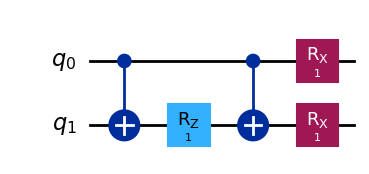

In [26]:
prepare_first_order(2,1,1,1,1).draw("mpl")

In [27]:
def prepare_second_order(n_qubits: int, t: float, delta: float, J: float, h:float) -> Circuit:
    second_order_trotter = QuantumCircuit(n_qubits)
    
    second_order_trotter= second_order_trotter.compose(H_1_block(n_qubits,t,delta/2,J))
    second_order_trotter= second_order_trotter.compose(H_2_block(n_qubits,t,delta,h))
    second_order_trotter= second_order_trotter.compose(H_1_block(n_qubits,t,delta/2,J))
    
    return second_order_trotter

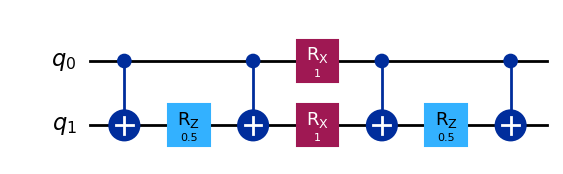

In [44]:
prepare_second_order(2,1,1,1,1).draw("mpl")

In [29]:
from qiskit.quantum_info import SparsePauliOp, Pauli

def observable_Z(nqubits: int):
    terms = []

    for i in range(nqubits):
        pauli_string = ['I'] * nqubits
        pauli_string[i] = 'Z'
        
        pauli_op = Pauli(''.join(pauli_string))
        terms.append((1.0 / nqubits, pauli_op))

    magnetization_obs = SparsePauliOp.from_list(terms)

    return magnetization_obs

In [30]:
def coeff(k: int):
    return (1/(4-4**(1/(2*k-1))))

In [31]:
def recursor(order:int,n_qubits: int, t: float, delta: float, h:float, J:float):
    if order==1:
        return prepare_first_order(n_qubits,t,delta,J,h)
    elif order%2:
        raise ValueError("cant do odd powers")
    elif order ==2: 
        return prepare_second_order(n_qubits, t, delta,J,h)
    else:
        S_recursor = QuantumCircuit(n_qubits)
        S1 = recursor(order-2,n_qubits,t,delta*coeff(order),h,J)
        S2 = recursor(order-2,n_qubits,t,(1-4*coeff(order))*delta,h,J)
        S_recursor=S_recursor.compose(S1)
        S_recursor=S_recursor.compose(S1)
        S_recursor=S_recursor.compose(S2)
        S_recursor=S_recursor.compose(S1)
        S_recursor=S_recursor.compose(S1)

        return S_recursor

In [32]:
def time_evolve(n_qubits: int, t: float, delta: float, order: int, h: float, J: float):
    t_steps = int(t // delta)
    times = np.linspace(0, t, t_steps + 1)
    magnetizations = []

    hamiltonian = get_ising_chain_hamiltonian(n_qubits, J, h)
    h_mat = hamiltonian.to_matrix()
    mag_op = observable_Z(n_qubits).to_matrix()

    psi_0 = np.zeros(2**n_qubits, dtype=complex)
    psi_0[0] = 1
    psi_t = psi_0.copy()

    for time in times:
        if time > 0:
            if order == 1:
                time_evolution_op = expm(-1j * delta * h_mat)
                psi_t = time_evolution_op @ psi_t
        
        mag_t = np.real(psi_t.conj().T @ (mag_op @ psi_t))
        magnetizations.append(mag_t)

    return times, magnetizations

In [37]:
def get_ising_chain_hamiltonian_terms(n_qubits: int, J: float, h: float):
    zz_terms = []
    x_terms = []

    for i in range(n_qubits - 1):
        zz_term[i], zz_term[i+1] = 'Z', 'Z'
        zz_terms.append((J, ''.join(zz_term)))

    for i in range(n_qubits):
        x_term = ['I'] * n_qubits
        x_term[i] = 'X'
        x_terms.append((h, ''.join(x_term)))

    return zz_terms, x_terms

def time_evolve(n_qubits: int, t: float, delta: float, order: int, h: float, J: float):

    t_steps = int(t // delta)
    times = np.linspace(0, t, t_steps + 1)
    magnetizations = []

    zz_terms, x_terms = get_ising_chain_hamiltonian_terms(n_qubits, J, h)
    mag_op = observable_Z(n_qubits).to_matrix()

    psi_0 = np.zeros(2**n_qubits, dtype=complex)
    psi_0[0] = 1

    psi_t = psi_0.copy()

    def apply_time_evolution_operator(psi, t_step):
        if order == 1:
            for coeff, pauli_string in zz_terms:
                h_mat = SparsePauliOp([pauli_string], [coeff]).to_matrix()
                psi = expm(-1j * delta * h_mat) @ psi
            for coeff, pauli_string in x_terms:
                h_mat = SparsePauliOp([pauli_string], [coeff]).to_matrix()
                psi = expm(-1j * delta * h_mat) @ psi
            
        elif order == 2:
            for coeff, pauli_string in x_terms:
                h_mat = SparsePauliOp([pauli_string], [coeff]).to_matrix()
                psi = expm(-1j * (delta/2) * h_mat) @ psi
            for coeff, pauli_string in zz_terms:
                h_mat = SparsePauliOp([pauli_string], [coeff]).to_matrix()
                psi = expm(-1j * delta * h_mat) @ psi
            for coeff, pauli_string in x_terms:
                h_mat = SparsePauliOp([pauli_string], [coeff]).to_matrix()
                psi = expm(-1j * (delta/2) * h_mat) @ psi
        
        return psi


    for time in times:
        if time > 0:
            psi_t = apply_time_evolution_operator(psi_t, delta)

        mag_t = np.real(psi_t.conj().T @ (mag_op @ psi_t))
        magnetizations.append(mag_t)

    return times, magnetizations

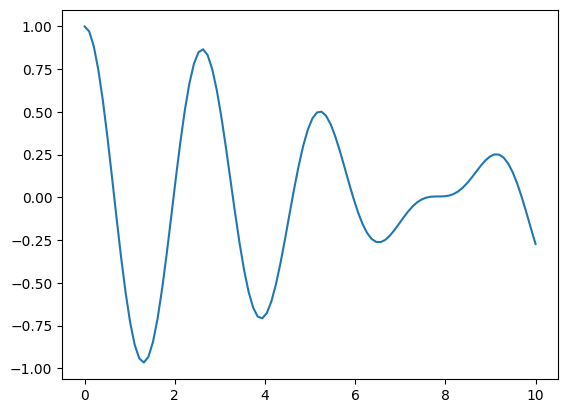

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Pauli

def get_ising_chain_hamiltonian(n_qubits: int, J: float, h: float) -> SparsePauliOp:
    pauli_strings = []

    for i in range(n_qubits - 1):
        # ZZ term for qubit pair (i, i+1)
        z_term = ['I'] * n_qubits
        z_term[i], z_term[i+1] = 'Z', 'Z'
        zz_string = ''.join(z_term)
        pauli_strings.append((zz_string, J))

    for i in range(n_qubits):
        x_term = ['I'] * n_qubits
        x_term[i] = 'X'
        x_string = ''.join(x_term)
        pauli_strings.append((x_string, h))

    return SparsePauliOp.from_list(pauli_strings)

def observable_Z(nqubits: int):
    terms = []

    for i in range(nqubits):
        pauli_string = ['I'] * nqubits
        pauli_string[i] = 'Z'
        
        z_string = ''.join(pauli_string)
        terms.append((z_string, 1.0 / nqubits))

    magnetization_obs = SparsePauliOp.from_list(terms)
    
    return magnetization_obs

def get_M(n_qubits: int, J: float, t: float, h: float) -> float:
    ham_op = get_ising_chain_hamiltonian(n_qubits, J, h)
    h_mat = ham_op.to_matrix()
    D, P = np.linalg.eigh(h_mat)
    exp_h = P @ np.diag(np.exp(-1j * t * D)) @ P.conj().T
    psi_0 = np.zeros(2**n_qubits)
    psi_0[0] = 1
    
    psi_t = exp_h @ psi_0

    mag_op = observable_Z(n_qubits).to_matrix()
    mag = np.real(psi_t.conj().T @ (mag_op @ psi_t))
    
    return mag
    
mag_arr = []
for i in t_arr:
    mag_arr.append(get_M(n_qubits,J,i,h))
plt.plot(t_arr,mag_arr)

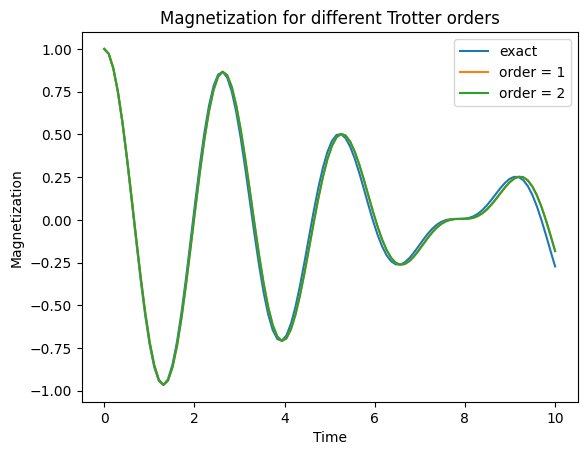

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm


exact_magnitudes = [get_M(n_qubits, J, t, h) for t in t_arr]
plt.plot(t_arr, exact_magnitudes, label="exact")

big_mag_arr = []
big_t_arr = []

orders = [1,2]
for order in orders:
    t_arr, mag_values = time_evolve(n_qubits, t, delta, order=order, h=h, J=J)
    big_mag_arr.append(mag_values)
    big_t_arr.append(t_arr)
    plt.plot(t_arr, mag_values, label=f"order = {order}")

plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.legend()
plt.title('Magnetization for different Trotter orders')
plt.show()

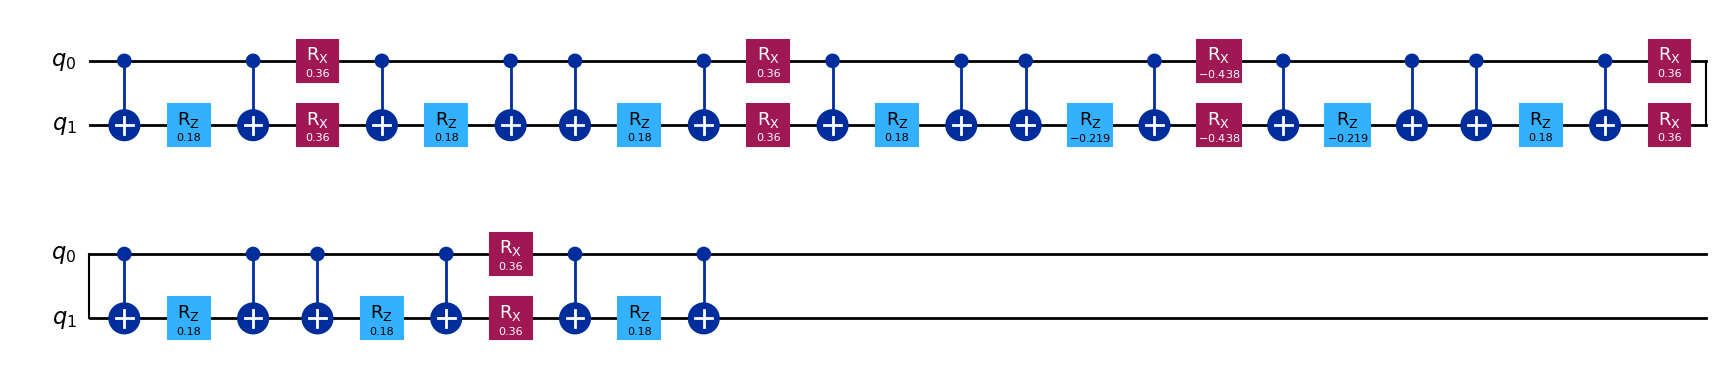

In [50]:
recursor(4,2,1,1,1,1).draw("mpl")

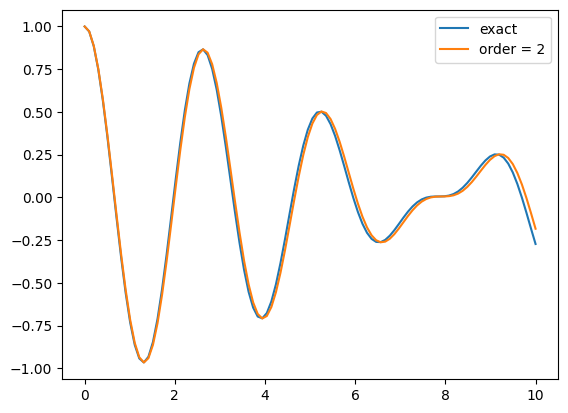

In [46]:
big_mag_arr = []
big_t_arr = []
orders = [2]
plt.plot(t_arr,mag_arr,label=f"exact")
for i in orders:
    t_arr, mag_values = time_evolve(n_qubits,t,delta, order=i,h=h,J=J)
    big_mag_arr.append(mag_values)
    big_t_arr.append(t_arr)
    plt.plot(t_arr,mag_values,label=f"order = {i}")

plt.legend()

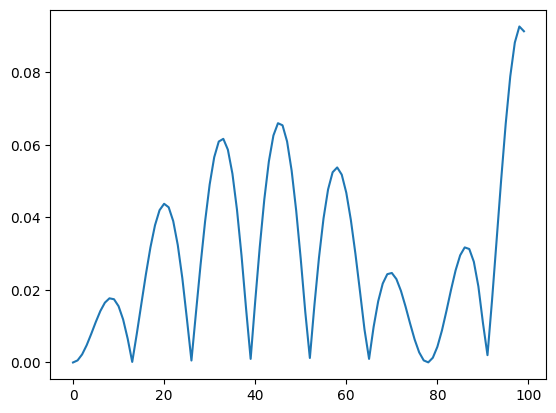

In [42]:
plt.plot(np.abs(np.array(mag_values)-np.array(mag_arr)))